<a href="https://colab.research.google.com/github/abhi-lejon/Neural-Networks/blob/master/Hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Dec  6 14:17:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    31W /  70W |    229MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U keras-tuner # Distributed hypermeter optimization framework for hyperparameter search

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.2)


In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import tensorflow_datasets as tfds
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
datasets,info=tfds.load(name='fashion_mnist',as_supervised=True,with_info=True,split=['train','test'])

In [ ]:
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

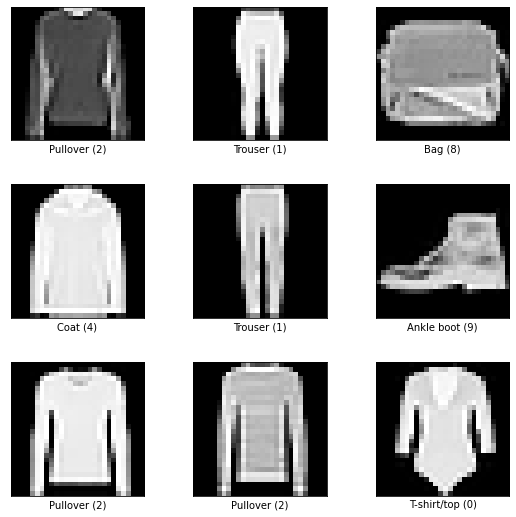

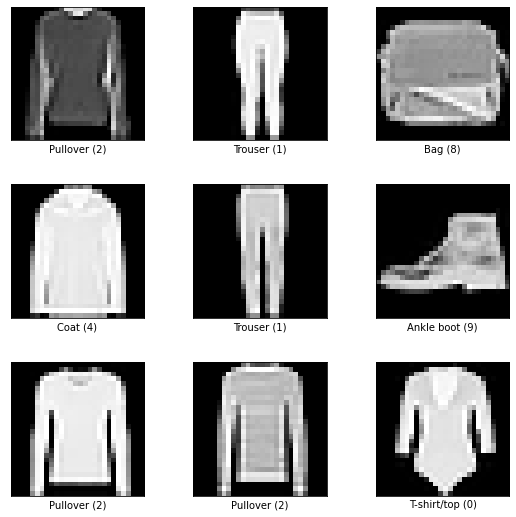

In [ ]:
image,label=tfds.load(name='fashion_mnist',with_info=True,split='train')
tfds.show_examples(image,label)                      

In [ ]:
fm_train,fm_test=datasets[0],datasets[1]
fm_val=fm_test.take(3000)
fm_test=fm_test.skip(3000)

In [ ]:
len(fm_test),len(fm_train),len(fm_val)

(7000, 60000, 3000)

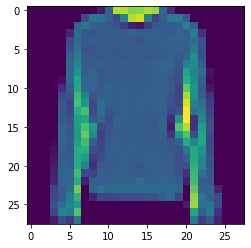

Label:2
Category:Pullover


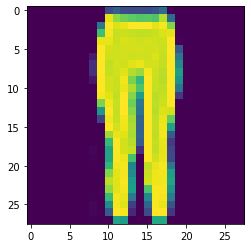

Label:1
Category:Trouser


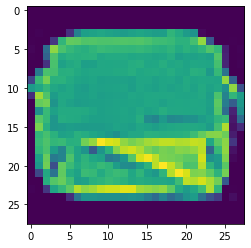

Label:8
Category:Bag


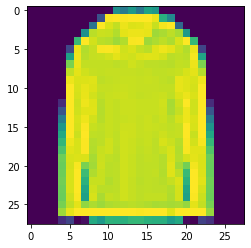

Label:4
Category:Coat


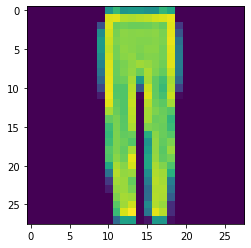

Label:1
Category:Trouser


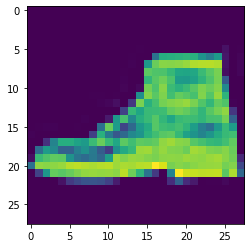

Label:9
Category:Ankle boot


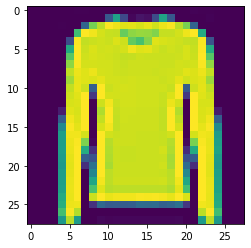

Label:2
Category:Pullover


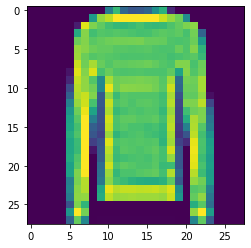

Label:2
Category:Pullover


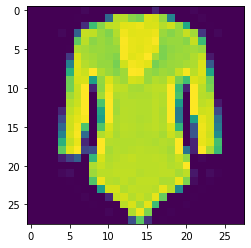

Label:0
Category:T-shirt/top


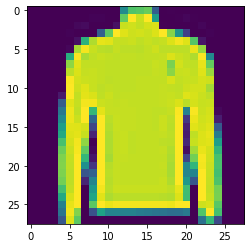

Label:2
Category:Pullover


In [ ]:
for i in fm_train.take(10):
  image,label=i[0],i[1]
  plt.figure()
  plt.imshow(image.numpy()[:,:,0])
  plt.show()
  print("Label:%d"%label.numpy())
  print("Category:%s"%info.features['label'].names[label.numpy()])

In [ ]:
def scale(image,label):
  images=tf.cast(image,tf.float32)
  images/=255.0
  return image,label

In [ ]:
def get_dataset(batch_size=64):
  train_dataset_scaled=fm_train.map(scale).shuffle(60000).batch(batch_size)
  test_dataset_scaled=fm_test.map(scale).batch(batch_size)
  val_dataset_scaled=fm_val.map(scale).batch(batch_size)
  return train_dataset_scaled,test_dataset_scaled,val_dataset_scaled

In [ ]:
!pip install -U keras-tuner
import kerastuner as kt

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.2)


In [ ]:
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
#Lets define the hypermeters to define
hp=HyperParameters()
hp.Choice('learning_rate',[1e-1,1e-3])
hp.Int('conv_blocks',3,4,default=3)
hp.Int('hidden_size',128,256,step=64,default=128)

128

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])
  
  return model

In [ ]:
def model(hp):
  model=tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
  hp_convo_units=hp.Int('convo_blocks',min_value=3,max_value=4,default=3)
  hp_hidden_units=hp.Int('hidden_units',min_value=128,max_value=256,step=64,default=128)
  hp_units=hp.Int('units',min_value=32,max_value=512,step=32,default=32) #Dense layer
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
  hp_activations=hp.Choice('activations',values=['relu','tanh','sigmoid'],default='relu')
  model.add(tf.keras.layers.Dense(units=hp_units,activation='relu'))
  model.add(tf.keras.layers.Dense(10))
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])
  return model

In [ ]:
import kerastuner as kt

tuner=kt.Hyperband(
    model,
    objective='val_accuracy',
    max_epochs=5
)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
convo_blocks (Int)
{'default': 3, 'conditions': [], 'min_value': 3, 'max_value': 4, 'step': 1, 'sampling': None}
hidden_units (Int)
{'default': 128, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 64, 'sampling': None}
units (Int)
{'default': 32, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
train_dataset,test_dataset,val_dataset=get_dataset()
train_dataset.cache() # When cached, the data will go to GPU memory
val_dataset.cache()

tuner.search(train_dataset,validation_data=val_dataset,epochs=5,callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model=tuner.get_best_models(1)[0]

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 192)               150720    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1930      
Total params: 152,650
Trainable params: 152,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
best_hyperparameters=tuner.get_best_hyperparameters(1)[0]

In [ ]:
best_hyperparameters.values

{'activations': 'relu',
 'convo_blocks': 4,
 'hidden_units': 192,
 'learning_rate': 0.0001,
 'tuner/bracket': 0,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units': 192}

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
convo_blocks: 4
hidden_units: 192
units: 192
learning_rate: 0.0001
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
activations: relu
Score: 0.82833331823349
Trial summary
Hyperparameters:
convo_blocks: 4
hidden_units: 128
units: 480
learning_rate: 0.001
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.828000009059906
Trial summary
Hyperparameters:
convo_blocks: 4
hidden_units: 192
units: 384
learning_rate: 0.0001
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8253333568572998
Trial summary
Hyperparameters:
convo_blocks: 4
hidden_units: 192
units: 480
learning_rate: 0.0001
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 30a2435deb5c9f50ad1322f653c6e6d1
Score: 0.8216666579246521
Trial summary
Hyperparameters:
convo_blo

In [ ]:
best_model.save('/tmp/fash.hdf5')

In [ ]:
!nvidia-smi

Sun Dec  6 14:34:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    30W /  70W |    303MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!ls -alrt /tmp/fash.hdf5

-rw-r--r-- 1 root root 1856640 Dec  6 14:34 /tmp/fash.hdf5


In [ ]:
tf.keras.backend.clear_session()
fash_model=tf.keras.models.load_model('/tmp/fash.hdf5',compile=True)

In [ ]:
_,accuracy=best_model.evaluate(test_dataset)

110/110 [==============================] - 0s 2ms/step - loss: 3.3988 - accuracy: 0.8200


In [ ]:
accuracy

0.8199999928474426

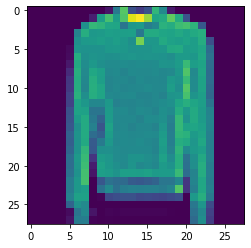

Actual_label:Pullover
Predicted_label:Pullover


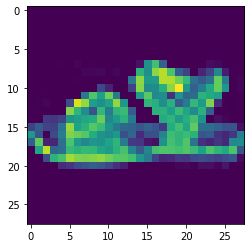

Actual_label:Sandal
Predicted_label:Sandal


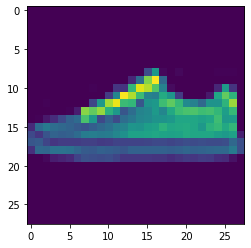

Actual_label:Sneaker
Predicted_label:Sneaker


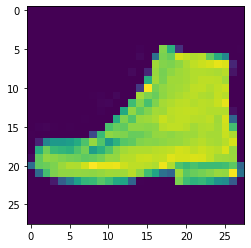

Actual_label:Ankle boot
Predicted_label:Ankle boot


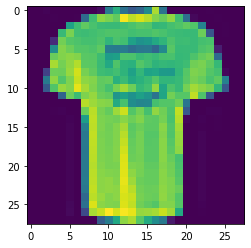

Actual_label:T-shirt/top
Predicted_label:T-shirt/top


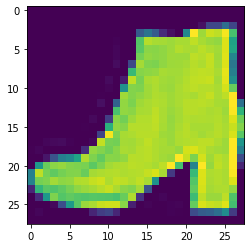

Actual_label:Ankle boot
Predicted_label:Ankle boot


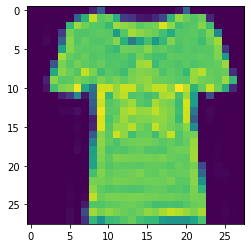

Actual_label:T-shirt/top
Predicted_label:T-shirt/top


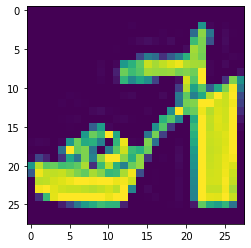

Actual_label:Sandal
Predicted_label:Sandal


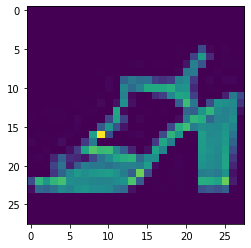

Actual_label:Sandal
Predicted_label:Sandal


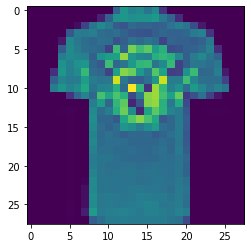

Actual_label:T-shirt/top
Predicted_label:Bag


In [ ]:
for fm_sample in fm_test.take(10):
  image,label=fm_sample[0],fm_sample[1]
  img=tf.keras.preprocessing.image.img_to_array(image)
  img=np.expand_dims(img,axis=0)
  img/=255.0
  pred=fash_model.predict(img)
  plt.figure()
  plt.imshow(image.numpy()[:,:,0].astype(np.float32))
  plt.show()
  print('Actual_label:%s'%info.features['label'].names[label.numpy()])
  print('Predicted_label:%s'%info.features['label'].names[np.argmax(pred)])

In [ ]:
pred

array([[ 0.09594157, -0.01247979,  0.09197158,  0.04242387, -0.06467199,
        -0.44697535,  0.00588774, -0.41453728,  0.10645039, -0.54272765]],
      dtype=float32)

In [ ]:
np.argmax(pred)

8